In [1]:

import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [2]:
df = pd.read_excel('../data_processed/men_ordinary_people.xlsx')

In [3]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
0,poem good editing correct wish poem recorded ishq rasul studio,Abdulhaqpashai2,2023-03-13,male,pashtun,0,positive,0.700000
1,people bad things response answer,Abdulhaqpashai2,2023-03-04,male,pashtun,0,negative,-0.700000
2,dude go ahead stupidity god lead us right path years use stupidity stupidity,Abdulhaqpashai2,2023-02-27,male,pashtun,0,negative,-0.378571
3,busy personal work may god bless dear brother,Abdulhaqpashai2,2023-02-25,male,pashtun,0,positive,0.050000
4,busy personal work may god bless,Abdulhaqpashai2,2023-02-24,male,pashtun,0,positive,0.050000


##### Drop Null, Empty and NaN valeus

In [4]:
df.dropna(subset=['text'], inplace=True) # remove nan values
df.drop_duplicates(subset=['text'], inplace=True) # remove duplicates


##### Clean Data

In [5]:
df['text'] = df['text'].str.replace('&amp;', ' ')
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [6]:
# df = pd.read_excel('../data_processed/men_ordinary_people.xlsx')

In [7]:
df[['text']].sample(5)

,text
7099,sreshthx question let know find solution
27533,arefyaqubi daryafarhad raminmazhar habibkhant zahrajoya
36709,heart asia afghanistan asiacup congratulations afghan campaign afghanistan afgvsl
43475,messenger allah said prayer changes destiny
19022,tvnewsaf nine afghan army officers graduate turkish defense university


##### Remove Text Less then 30 characters

In [8]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [9]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [10]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [11]:
from nltk.corpus import stopwords
import nltk

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df

df = remove_stopwords(df)


##### Convert Timezone

In [12]:
# df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [13]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
27887,conversation ahmad massoud leader national resistance front important points reflection emphasis freedom justice democracy evidence awareness nativedemocratic demands afghan citizens responsible targeted criticism global regional diplomacy towards afghanistan justified insisting right people resist,ForughTabish,2022-07-12,male,tajik,0,positive,0.257143
27400,story seven months financial almeida written shahan karunathilaka painful terrible account countless crimes year civil war sri lanka author writes narrates unrequited killing conflicting parties bitter sarcasm language dead awakened conscience sharp reckless language,ForughTabish,2022-11-22,male,tajik,0,negative,-0.303571
12299,nimat long land see mercy allah killed hundreds innocent afghans every day got three four marriages help paktika beat saudis wolves want mercy hypocrites keep eye disasters god,MulakhilZ,2022-07-18,male,pashtun,0,positive,0.083333
1804,majeedqarar socalled minister punch ordinary isi servant face welcome fifth edition,afghanistan1290,2022-12-02,male,pashtun,0,positive,0.275000


In [14]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
27456,ibrahimii congratulations dr sahib soon benefit fruits efforts produce knowledge awareness,ForughTabish,2022-10-28,male,tajik,0,neutral,0.000000
20391,hkmtall muhibullahjaba refugee kblmunicipality kabulpolicehq st,BOSSKUNDUZI,2023-02-18,male,pashtun,0,neutral,0.000000
39832,shahnaz iran formed immigration organization governments effort form organization order facilitate accommodation social services immigrants,RezayeSabers,2022-12-19,male,tajik,0,positive,0.033333
33046,maryamhmshhry tamimasey yes three types resistance taliban defectors taken third honor,HamedRahimii,2022-05-06,male,tajik,0,neutral,0.000000


##### Convert Timezone to datetime

In [15]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)


##### Drop the whole rows which is >=2020

In [16]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)

##### Remove Great March, 30

In [17]:
df.shape

(47939, 8)

In [18]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
10414,akbari god bless akbari saeb always shine,MulakhilZ,2023-02-12,male,pashtun,0,neutral,0.000000
34994,drrosena new staff new services faster treatment better mental health prevention watchword thats labours bold,haqmal_n,2022-10-01,male,pashtun,0,positive,0.201212
4160,sameerbedrud ahmed massoud emphasizing war solution convince anyone taliban group stop fighting effect,AminNangialai,2022-09-18,male,pashtun,0,neutral,0.000000
17309,rule taliban practically turning land fifth province pakistan support taliban ghani based ethnic preferences participating sale land land certainly proud pakistans slavery disgrace,azadi102938,2022-03-04,male,tajik,0,positive,0.800000


##### Check How Many accounts are there

In [19]:
len(df['name'].unique())

54

##### Labeling Process

In [20]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [21]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [22]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     19207
positive    17767
negative    10965
Name: count, dtype: int64
Total Counts: 28732


##### Calculate positive tweets and percentage for women, single user

In [23]:
women_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'male'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from men:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from men: 17767 ( 37.06168255491354 %)


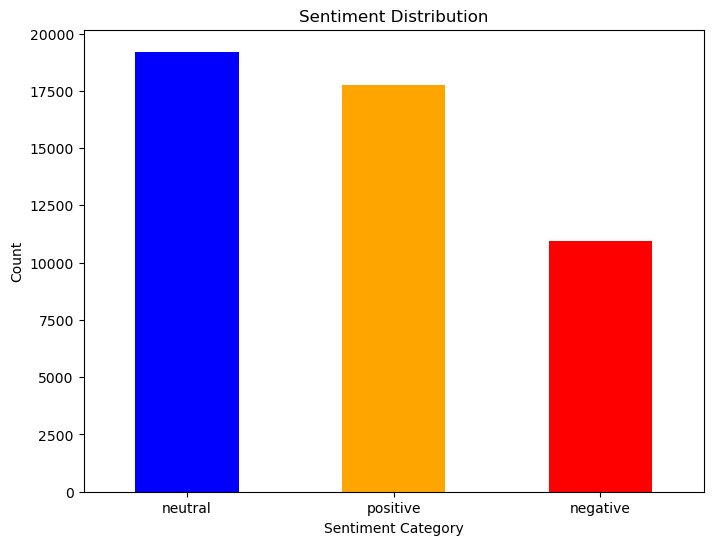

Sentiment Distribution: 28732


In [24]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Content Analysis

In [25]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  4383


##### Code Schema

In [26]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [27]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
12665,long doors girl school opened imposition sharia limits turned legal punishment international law women rights work permits given inclusive government formed un never recognize afghanistan coudjndpef,positive,0.050000,male,1,"[women, women, school]"
23424,taliban member trying place remote control bomb watermelon mass murder large civilian population bombed hazara school children university students demonstrations sports clubs wedding halls stop hazara genocide,positive,0.057143,male,1,"[school, school, university]"
25845,karbalaie media three hazara girl died poisoned families threatened tell media students,neutral,0.000000,male,1,"[women, school]"
4368,alinazary nrfafgs leader ahmadmassoud officially launched women council council made women walks l,neutral,0.000000,male,1,[women]
4910,massoudiyem performance recorded history history write brave women country st anniversary national hero roads kabul,positive,0.800000,male,1,[women]


##### Visualization

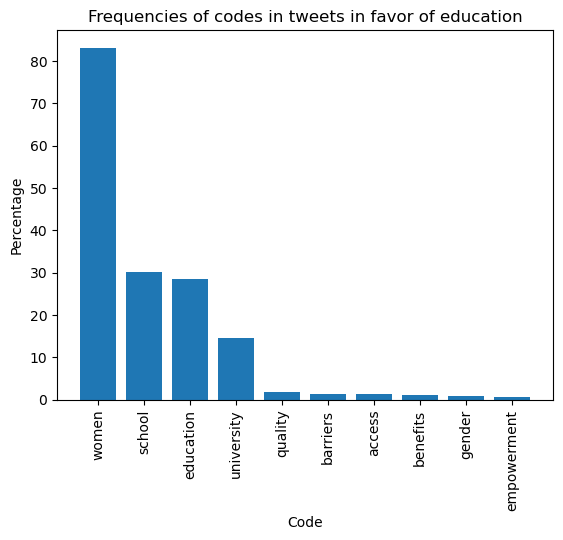

In [28]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    488
neutral     748
positive    783
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    227
neutral     284
positive    511
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    292
neutral     350
positive    350
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    138
neutral     221
positive    202
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative    365
neutral     521
positive    550
Name: text, dtype: int64


In [30]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13
neutral     14
positive    22
Name: text, dtype: int64


In [31]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13 (26.5%)
neutral     14 (28.6%)
positive    22 (44.9%)
Name: text, dtype: object


##### Average sentiment

In [32]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.05399835330957779


##### Sentiment Category

In [33]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)                     0.069273
(education, access)              0.003516
(education, access, barriers)    0.392857
(education, barriers)            0.321429
(education, benefits)            0.119722
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [34]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment Men:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment Men:
T-statistic: 41.46310984576854
P-value: 0.0


In [35]:
men_education_tweets = df[df['text'].str.contains('women education', case=False)]
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment for Women Education Tweets:
T-statistic: 1.5454343443610505
P-value: 0.1288094701752502


#### Calculate the sentiment scores for tweets containing each keyword

In [36]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.05399835330957779


##### Chi-square test of independence

In [37]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [38]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender      male
sentiment       
negative   10965
neutral    19207
positive   17767


In [39]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Gender and Label:")
print(cross_tab)

Cross-Tabulation of Gender and Label:
label       0     1
gender             
male    43556  4383


##### Calculate descriptive statistics for women


In [40]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for men ordinary people:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for men ordinary people:
Mean Sentiment: 0.05304848831657193
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.2801245010147825
Quartiles of Sentiment: [0.   0.   0.15]


##### Frequent Words

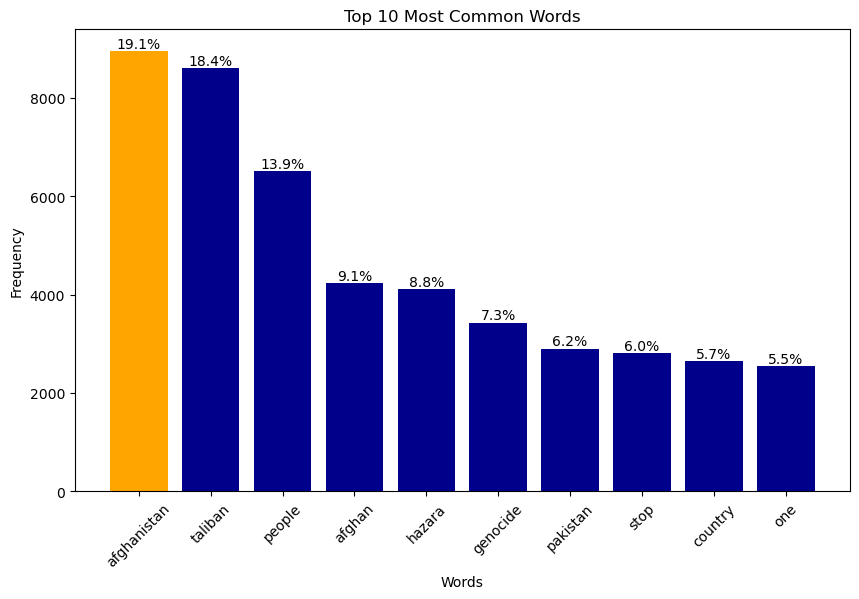

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


In [48]:
for word, count in most_common_words:
    print(f'{word}: {count}')


afghanistan: 8944
taliban: 8614
people: 6517
afghan: 4235
hazara: 4117
genocide: 3434
pakistan: 2905
stop: 2807
country: 2654
one: 2552


##### Time Series

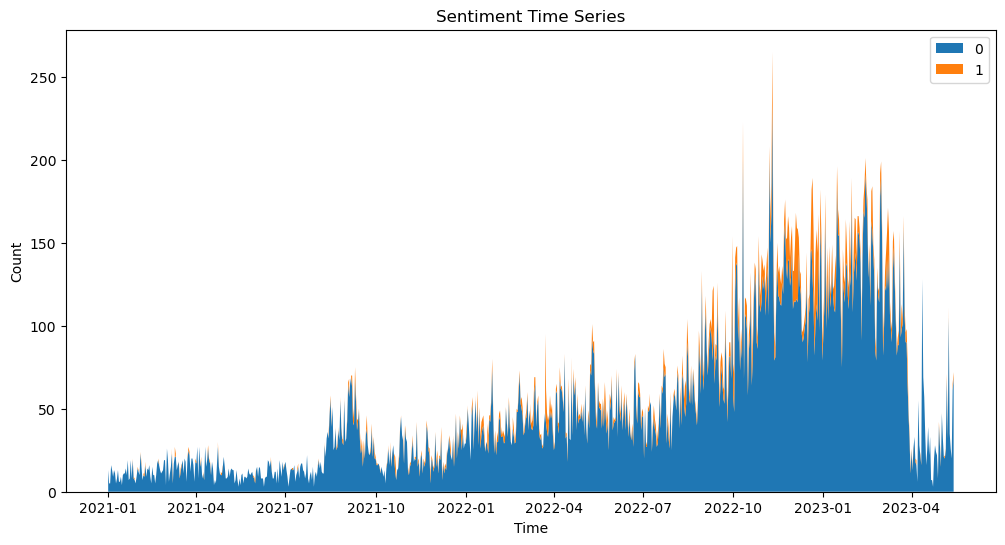

In [42]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Frequent Tweet

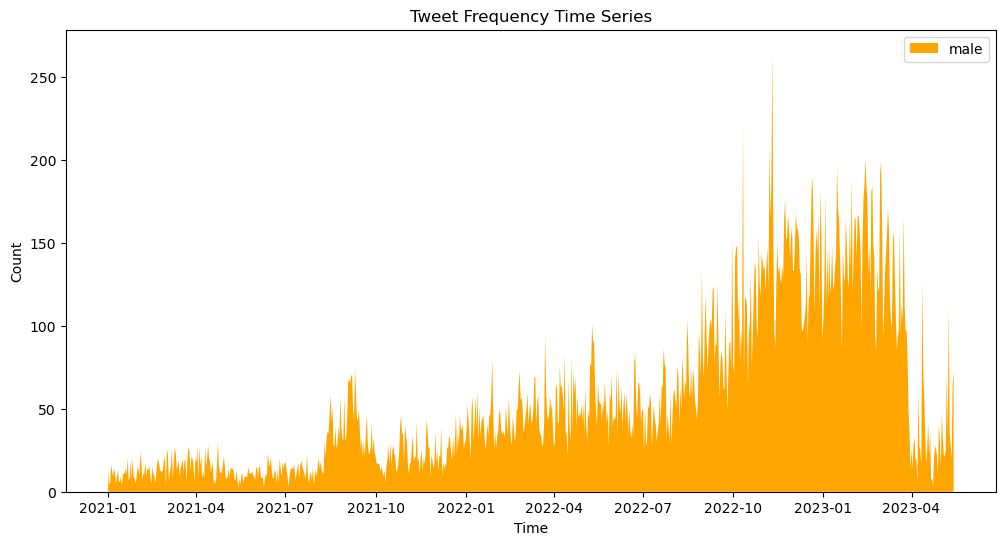

In [43]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


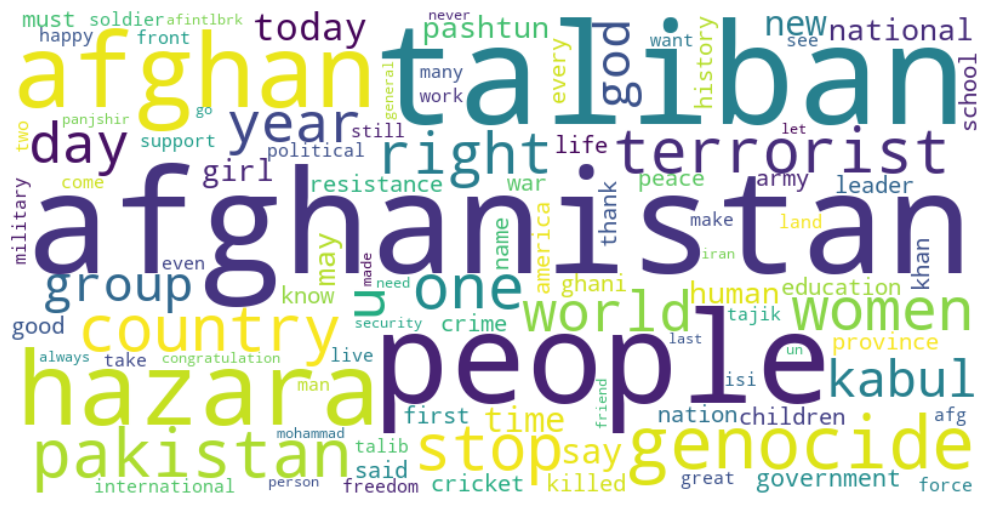

In [44]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


In [45]:
df[['text']].sample(7)

,text
39875,tolonews unfortunate people afghanistan call illiterate wahhabi amirul momineen
41781,bas key longevity government valuing scientists students difference men women open girl school
40141,iranintl network called media rather collection falsehoods appropriate name
40868,mediahamasa sediqsediqqi america started evil policy people afghanistan
25315,khaama taliban extremist fundamentalist ideology nothing taliban foreigner familiarity
33880,happy birthday congratulate dear compatriots great success
47621,ananthisha newest hero saadmohseni brave optimistic founder tolo news afganistan feel bravest h


In [46]:
df.shape

(47939, 8)

In [47]:
df.to_excel('../data_processed/men_ordinary_people.xlsx',index=False)